In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np
import re
df_test = pd.read_csv(r'C:\Users\abhis\OneDrive\Desktop\week4\data\test.csv', header=None, names=['polarity', 'title', 'review'])
print(df_test.head())
print(df_test['polarity'].value_counts())


   polarity                                              title  \
0         2                                           Great CD   
1         2  One of the best game music soundtracks - for a...   
2         1                   Batteries died within a year ...   
3         2              works fine, but Maha Energy is better   
4         2                       Great for the non-audiophile   

                                              review  
0  My lovely Pat has one of the GREAT voices of h...  
1  Despite the fact that I have only played a sma...  
2  I bought this charger in Jul 2003 and it worke...  
3  Check out Maha Energy's website. Their Powerex...  
4  Reviewed quite a bit of the combo players and ...  
polarity
2    200000
1    200000
Name: count, dtype: int64


In [3]:
len(df_test)

400000

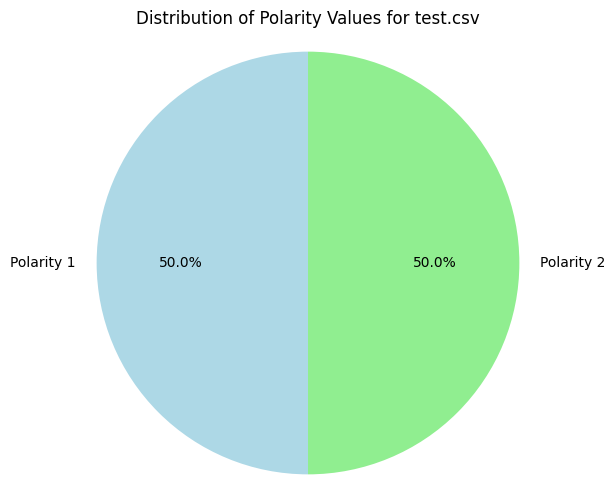

In [ ]:
import matplotlib.pyplot as plt
counts = [len(df_test[df_test['polarity'] == 1]), len(df_test[df_test['polarity'] == 2])]
labels = ['Polarity 1', 'Polarity 2']
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.title('Distribution of Polarity Values for test.csv')
plt.axis('equal')  # Equal aspect ratio ensures a circular pie
plt.show()

In [ ]:
df_test = df_test[df_test['polarity'].isin([1, 2])]
df_test = df_test.dropna(subset=['review'])
print(f"Filtered dataset shape: {df_test.shape}")
print(df_test['polarity'].value_counts())


Filtered dataset shape: (400000, 3)
polarity
2    200000
1    200000
Name: count, dtype: int64


In [ ]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"<.*?>", "", text) 
    text = re.sub(r"[^a-z0-9\s.,!?']", " ", text) 
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [ ]:
df_test['cleaned_review'] = df_test['review'].apply(clean_text)
print(df_test[['review', 'cleaned_review']].head())


                                              review  \
0  My lovely Pat has one of the GREAT voices of h...   
1  Despite the fact that I have only played a sma...   
2  I bought this charger in Jul 2003 and it worke...   
3  Check out Maha Energy's website. Their Powerex...   
4  Reviewed quite a bit of the combo players and ...   

                                      cleaned_review  
0  my lovely pat has one of the great voices of h...  
1  despite the fact that i have only played a sma...  
2  i bought this charger in jul 2003 and it worke...  
3  check out maha energy's website. their powerex...  
4  reviewed quite a bit of the combo players and ...  


In [ ]:
df_test['cleaned_review'] = df_test['review'].apply(clean_text)
print(df_test[['review', 'cleaned_review']].head())


                                              review  \
0  My lovely Pat has one of the GREAT voices of h...   
1  Despite the fact that I have only played a sma...   
2  I bought this charger in Jul 2003 and it worke...   
3  Check out Maha Energy's website. Their Powerex...   
4  Reviewed quite a bit of the combo players and ...   

                                      cleaned_review  
0  my lovely pat has one of the great voices of h...  
1  despite the fact that i have only played a sma...  
2  i bought this charger in jul 2003 and it worke...  
3  check out maha energy's website. their powerex...  
4  reviewed quite a bit of the combo players and ...  


In [ ]:
df_test['review_length'] = df_test['cleaned_review'].apply(lambda x: len(x.split()))
print(df_test[['cleaned_review', 'review_length']].head())
print(f"\nReview length stats:\n{df_test['review_length'].describe()}")


                                      cleaned_review  review_length
0  my lovely pat has one of the great voices of h...            104
1  despite the fact that i have only played a sma...            134
2  i bought this charger in jul 2003 and it worke...             54
3  check out maha energy's website. their powerex...             32
4  reviewed quite a bit of the combo players and ...             65

Review length stats:
count    400000.000000
mean         74.673272
std          42.671076
min           2.000000
25%          39.000000
50%          66.000000
75%         104.000000
max         217.000000
Name: review_length, dtype: float64


In [ ]:
df_test['length_bin'] = pd.qcut(df_test['review_length'], q=5, labels=False)
print(df_test[['review_length', 'length_bin']].head(10))
print("\nLength bin counts:")
print(df_test['length_bin'].value_counts())


   review_length  length_bin
0            104           3
1            134           4
2             54           1
3             32           0
4             65           2
5             66           2
6             78           2
7             38           1
8             57           2
9            147           4

Length bin counts:
length_bin
0    82367
3    80234
2    79983
4    79304
1    78112
Name: count, dtype: int64


In [ ]:
sample_size = 400000 
n_bins = df_test['length_bin'].nunique()
samples_per_group = sample_size // (2 * n_bins)

sampled_df_test = df_test.groupby(['polarity', 'length_bin'], group_keys=False).apply(
    lambda x: x.sample(min(len(x), samples_per_group), random_state=42)
).reset_index(drop=True)


print("Sampled polarity counts:")
print(sampled_df_test['polarity'].value_counts())
print("\nSampled length_bin counts:")
print(sampled_df_test['length_bin'].value_counts())


Sampled polarity counts:
polarity
1    193368
2    192399
Name: count, dtype: int64

Sampled length_bin counts:
length_bin
2    78555
1    78112
3    77318
4    77016
0    74766
Name: count, dtype: int64


C:\Users\abhis\AppData\Local\Temp\ipykernel_12452\1912657512.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df_test = df_test.groupby(['polarity', 'length_bin'], group_keys=False).apply(


In [ ]:
from pathlib import Path
Path(r"C:\Users\abhis\OneDrive\Desktop\week4\data").mkdir(parents=True, exist_ok=True)
sampled_df_test[['cleaned_review', 'title', 'polarity']].to_csv("data/cleaned_sampled_test.csv", index=False)
print("Saved cleaned and sampled training data to data/cleaned_sampled_test.csv")


Saved cleaned and sampled training data to data/cleaned_sampled_test.csv


In [ ]:
df_test['polarity'] = df_test['polarity'].map({1: 0, 2: 1})
print("Unique polarity values:", df_test['polarity'].unique())
print("Polarity dtype:", df_test['polarity'].dtype)
print(df_test.head())
print(f"Dataset size: {len(df_test)}")

Unique polarity values: [1 0]
Polarity dtype: int64
   polarity                                              title  \
0         1                                           Great CD   
1         1  One of the best game music soundtracks - for a...   
2         0                   Batteries died within a year ...   
3         1              works fine, but Maha Energy is better   
4         1                       Great for the non-audiophile   

                                              review  \
0  My lovely Pat has one of the GREAT voices of h...   
1  Despite the fact that I have only played a sma...   
2  I bought this charger in Jul 2003 and it worke...   
3  Check out Maha Energy's website. Their Powerex...   
4  Reviewed quite a bit of the combo players and ...   

                                      cleaned_review  review_length  \
0  my lovely pat has one of the great voices of h...            104   
1  despite the fact that i have only played a sma...            134   
2

In [11]:
def simple_tokenizer(text):
    text = text.lower().strip()
    tokens = text.split()
    return tokens

df_test['tokens'] = df_test['cleaned_review'].apply(simple_tokenizer)

print(df_test['tokens'].head())


0    [my, lovely, pat, has, one, of, the, great, vo...
1    [despite, the, fact, that, i, have, only, play...
2    [i, bought, this, charger, in, jul, 2003, and,...
3    [check, out, maha, energy's, website., their, ...
4    [reviewed, quite, a, bit, of, the, combo, play...
Name: tokens, dtype: object


# till here everything was exactly same as for train set

In [12]:
import pickle
with open(r'C:\Users\abhis\OneDrive\Desktop\week4\Sequence Modelling Basics\word2idx.pkl', 'rb') as f:
    word2idx = pickle.load(f)


In [ ]:
def tokens_to_indices(tokens):
    return [word2idx.get(token, word2idx["<UNK>"]) for token in tokens]

# Apply it to test set
df_test['indexed_tokens'] = df_test['tokens'].apply(tokens_to_indices)
print(df_test['indexed_tokens'].head())


0    [21, 1961, 5995, 40, 26, 7, 2, 47, 2302, 7, 76...
1    [922, 2, 378, 13, 4, 20, 53, 481, 5, 251, 2575...
2    [4, 93, 8, 1933, 11, 1, 4007, 3, 10, 333, 796,...
3    [584, 42, 1, 1, 4069, 86, 1, 1, 1, 1933, 213, ...
4    [3294, 243, 5, 229, 7, 2, 4955, 1499, 3, 14, 5...
Name: indexed_tokens, dtype: object


In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 150  # same as used in train

df_test['padded_tokens'] = list(pad_sequences(df_test['indexed_tokens'], maxlen=max_len, padding='post', truncating='post'))
print(df_test['padded_tokens'].head())


0    [21, 1961, 5995, 40, 26, 7, 2, 47, 2302, 7, 76...
1    [922, 2, 378, 13, 4, 20, 53, 481, 5, 251, 2575...
2    [4, 93, 8, 1933, 11, 1, 4007, 3, 10, 333, 796,...
3    [584, 42, 1, 1, 4069, 86, 1, 1, 1, 1933, 213, ...
4    [3294, 243, 5, 229, 7, 2, 4955, 1499, 3, 14, 5...
Name: padded_tokens, dtype: object


In [15]:
import torch
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(np.array(texts), dtype=torch.long)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]


In [ ]:
# just like we did for train set
test_dataset = ReviewDataset(df_test['padded_tokens'].tolist(), df_test['polarity'])
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Sanity check
sample_test_batch = next(iter(test_loader))
print("Test batch shapes:", sample_test_batch[0].shape, sample_test_batch[1].shape)


Test batch shapes: torch.Size([128, 150]) torch.Size([128])
